In [3]:
import torch
import pandas as pd
from pandas import DataFrame

from skimage import io, transform, color
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import dataset, dataloader, Dataset
from torchvision import transforms, utils

In [2]:
torch.cuda.is_available()

True

In [3]:
# https://github.com/Spandan-Madan/Pytorch_fine_tuning_Tutorial/blob/master/main_fine_tuning.py
# looks how the model is trained

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from dataloader import load_data, ImageDataset, Rescale, ToTensor
train_df, test_df = load_data()
print("Train:", train_df.shape)
print("Test:", test_df.shape)

Train: (1700, 3)
Test: (300, 3)


In [5]:

train_dataset = ImageDataset(train_df,
                                   transform=transforms.Compose([
                                       Rescale((320, 240)),
                                       # RandomCrop(224),
                                       ToTensor()
                                   ]))


test_dataset = ImageDataset(test_df,
                             transform=transforms.Compose([
                                 Rescale((320, 240)),
                                 # RandomCrop(224),
                                 ToTensor()
                             ]))



trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=1)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                          shuffle=True, num_workers=1)



In [8]:
from model import Net
net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (local_response_norm): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (max_pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(512, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv7): Conv2d(256, 128, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv8): Conv2d(128, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (deconv): ConvTranspose2d(32, 1, kernel_size=(8, 8), stride=(4, 4), bias=False)
)


In [48]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR
import torch.nn as nn

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

scheduler = ExponentialLR(optimizer, gamma=0.9)


In [50]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # name, image, fix_map = data
        image = data['image'].to(device)
        fix_map = data['fix_map'].to(device)
        # print("image size", data['image'].size(), "fix_map size", data['fix_map'].size())
        # break
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(image)
        loss = criterion(outputs, fix_map)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')



[1,   200] loss: 0.001
[1,   400] loss: 0.001
[2,   200] loss: 0.001
[2,   400] loss: 0.001
Finished Training


In [21]:
torch.save(net.state_dict(), './model_01.pth')

In [27]:
mm = Net()
mm.load_state_dict(torch.load("./model_01.pth"))
mm.eval()

Net(
  (conv1): Conv2d(3, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (local_response_norm): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (max_pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(512, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(512, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv7): Conv2d(256, 128, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv8): Conv2d(128, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (deconv): ConvTranspose2d(32, 1, kernel_size=(8, 8), stride=(4, 4), bias=False)
)

In [29]:

i = mm(data['image'].float())
i.shape

torch.Size([4, 1, 320, 240])

In [44]:
sam = i[2, :, :, :]

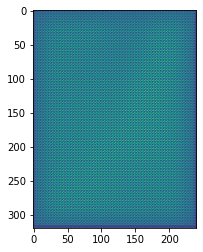

In [45]:
plt.imshow(sam.permute(1, 2, 0).detach().numpy())

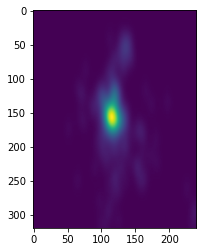

In [47]:

plt.imshow(data['fix_map'][2].permute(1, 2, 0).detach().numpy())

In [43]:
i[0, :, :, :]

tensor([[[ 0.0067,  0.0130, -0.0020,  ...,  0.0027,  0.0025,  0.0056],
         [ 0.0066,  0.0102,  0.0016,  ..., -0.0018, -0.0009,  0.0086],
         [ 0.0078, -0.0058, -0.0010,  ..., -0.0014,  0.0092, -0.0034],
         ...,
         [ 0.0059,  0.0013,  0.0040,  ..., -0.0008, -0.0002, -0.0055],
         [ 0.0007,  0.0133,  0.0017,  ..., -0.0069,  0.0009, -0.0044],
         [-0.0020,  0.0033,  0.0028,  ..., -0.0019, -0.0018,  0.0012]]],
       grad_fn=<SliceBackward0>)

In [3]:
def fit();

SyntaxError: invalid syntax (689076805.py, line 1)